# Perform deconvolution using Richardson-Lucy with an RGB image

## Load data and prepare operators

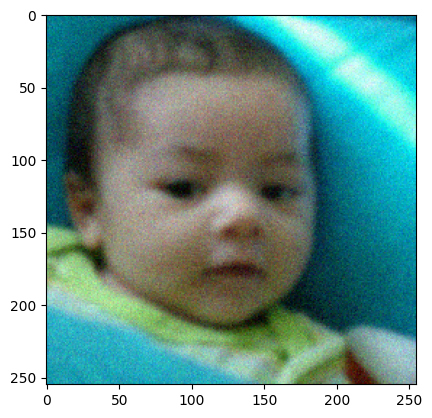

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import richardon_lucy as rl
import noise
import gaussian_blur
from PIL import Image

device = "cuda"

k_size = 63
k_std = 2.0
n_std = 0.05
n_rate = 1.0

# Load the data
ref = Image.open('img/00000.png')
ref = torch.from_numpy(np.array(ref)).unsqueeze(0).to(device).float() / 255.0
ref = ref[:, :-1, :-1, :-1]
ref = ref.permute(0, 3, 1, 2)


gaussianblur = gaussian_blur.GaussianBlur(k_size, k_std, channels=3).to(device)
k_ref = gaussianblur.get_kernel().view(1, 1, k_size, k_size).to(device)

with torch.no_grad():
    # noiser = noise.PoissonNoise(n_rate)
    noiser = noise.GaussianNoise(n_std)

    # Blur the image
    y = gaussianblur(ref)

    # Add noise
    y = noiser(y)

    y = torch.clamp(y, 1e-12, 1.0)

plt.imshow(y[0].permute(1, 2, 0).cpu().numpy())
plt.show()

## Perform the non-blind deconvolution

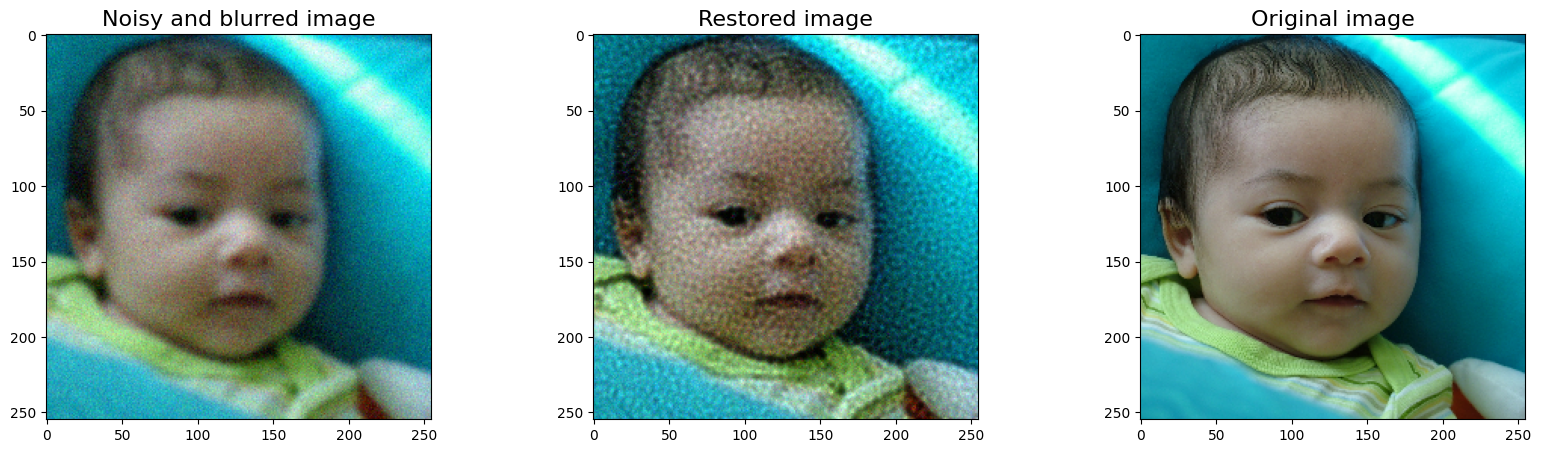

In [3]:
x_0 = y

res = rl.richardson_lucy(y, x_0, k_ref, steps=50, clip=True, filter_epsilon=1e-6)

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.imshow(y[0].permute(1, 2, 0).cpu().numpy())
plt.title('Noisy and blurred image', fontsize=16)
plt.subplot(1, 3, 2)
plt.imshow(res[0].permute(1, 2, 0).cpu().numpy())
plt.title('Restored image', fontsize=16)
plt.subplot(1, 3, 3)
plt.imshow(ref[0].permute(1, 2, 0).cpu().numpy())
plt.title('Original image', fontsize=16)
plt.show()

## Perform the blind deconvolution

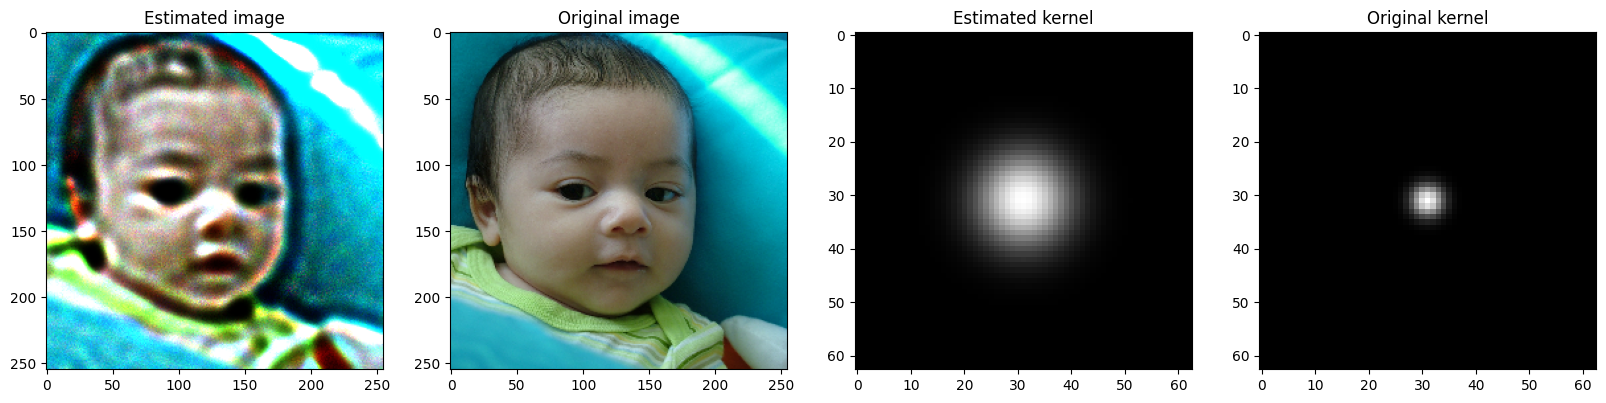

In [8]:
x_0 = y

# Different initializations for the kernel
gaussianblur = gaussian_blur.GaussianBlur(k_size, 6.0).to(device)

k_0 = gaussianblur.get_kernel().view(1, 1, k_size, k_size).to(device)
# k_0 = torch.ones_like(k_ref) / torch.sum(torch.ones_like(k_ref))
# k_0 = k_ref

steps = 40
k_steps = 1
x_steps = 1

filter_epsilon = 1e-12
clip = True
observation = y
# k_0 = k

res_img, res_k = rl.blind_richardson_lucy(observation, x_0, k_0, steps=steps, k_steps=k_steps, x_steps=x_steps, clip=clip, filter_epsilon=filter_epsilon)

plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(res_img[0].permute(1, 2, 0).cpu().numpy())
plt.title('Estimated image')
plt.subplot(1, 4, 2)
plt.imshow(ref[0].permute(1, 2, 0).cpu().numpy())
plt.title('Original image')
plt.subplot(1, 4, 3)
plt.imshow(res_k[0, 0].cpu().numpy(), cmap="gray")
plt.title('Estimated kernel')
plt.subplot(1, 4, 4)
plt.imshow(k_ref[0, 0].cpu().numpy(), cmap="gray")
plt.title('Original kernel')
plt.show()

## Perform the blind deconvolution with an animation

The deconvolution is performed with a 3D kernel. There is one independent PSF for each channel.
This implementation leads to noticable issues during the deconvolution process.

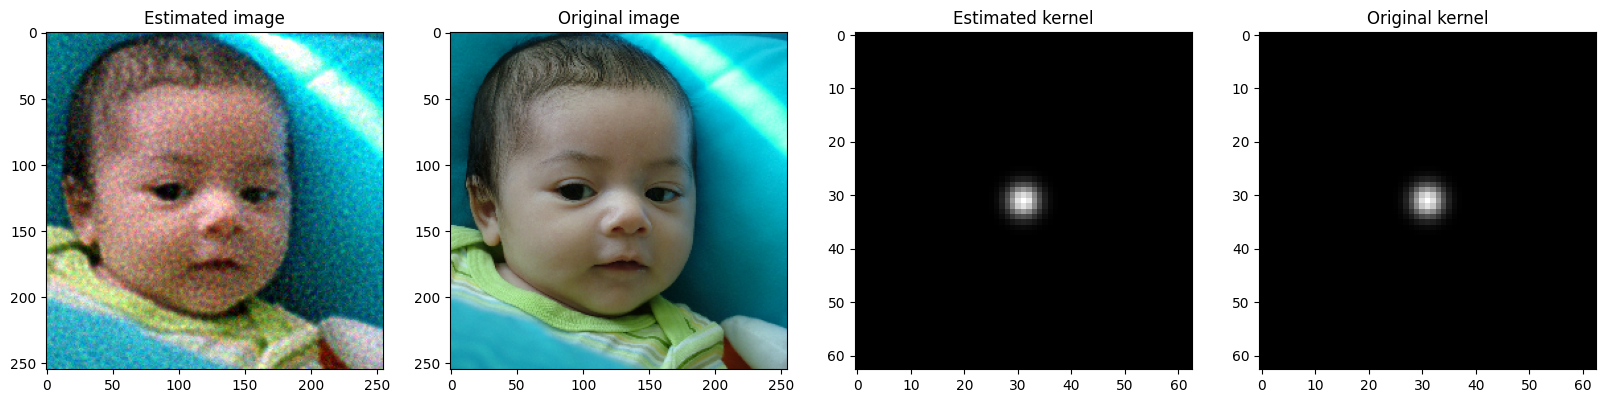

Step :  19


In [15]:
import torch.nn.functional as F
from IPython import display

# Different initializations for the image
# x_0 = torch.ones_like(y)
x_0 = y


# Different initializations for the kernel
gaussianblur = blur.GaussianBlur(k_size, 6.0).to(device)

# k_0 = gaussianblur.get_kernel().view(1, 1, k_size, k_size).to(device)
# k_0 = torch.ones_like(k) / torch.sum(torch.ones_like(k))
k_0 = k_ref

steps = 20
k_steps = 1
im_steps = 1

filter_epsilon = 1e-12
clip = True
observation = y

with torch.no_grad():

    k = k_0.clone().float()
    
    # For RGB images
    if(x_0.shape[1] == 3):
        k = k.repeat(1, 3, 1, 1)
        
    im_deconv = x_0.clone().float()
    
    k_T = torch.flip(k, dims=[2, 3])  
    im_deconv_T = torch.flip(im_deconv, dims=[2, 3])
    
    eps = 1e-12
    pad_im = (k.size(2) // 2, k.size(2) // 2, k.size(3) // 2, k.size(3) // 2)
    pad_k = (im_deconv.size(2) // 2, im_deconv.size(2) // 2, im_deconv.size(3) // 2, im_deconv.size(3) // 2)
    
    for i in range(steps):
        
        # Display the image
        display.clear_output(wait=True)  # Clear the previous output

        plt.figure(figsize=(20, 5))
        plt.subplot(1, 4, 1)
        plt.imshow(im_deconv[0].permute(1, 2, 0).cpu().numpy())
        plt.title('Estimated image')
        plt.subplot(1, 4, 2)
        plt.imshow(ref[0].permute(1, 2, 0).cpu().numpy())
        plt.title('Original image')
        plt.subplot(1, 4, 3)
        plt.imshow(k[0, 0].cpu().numpy(), cmap="gray")
        plt.title('Estimated kernel')
        plt.subplot(1, 4, 4)
        plt.imshow(k_ref[0, 0].cpu().numpy(), cmap="gray")
        plt.title('Original kernel')
        plt.show()
        
        print("Step : ", i)
        
        # Kernel estimation
        # The issue with the offset is probably here, as there is no offset when using k as initialization
        
        for m in range(k_steps):      
            
            k = k.swapaxes(0, 1)
            conv11 = F.conv2d(F.pad(im_deconv, pad_im, mode='replicate'), k, groups=3) + eps
            
            if filter_epsilon:
                relative_blur = torch.where(conv11 < filter_epsilon, 0.0, observation / conv11)
            else:
                relative_blur = observation / conv11
            
            k = k.swapaxes(0, 1)
            im_deconv_T = im_deconv_T.swapaxes(0, 1)
            im_mean = F.conv2d(torch.ones_like(F.pad(k, pad_k)), im_deconv_T, groups=3)
            # im_mean = F.conv2d(F.pad(torch.ones_like(k), pad_k, mode='replicate'), im_deconv_T)
            
            if filter_epsilon:
                k = torch.where(im_mean < filter_epsilon, 0.0, k / im_mean)
            else:
                k /= im_mean

            conv12 = F.conv2d(F.pad(relative_blur, pad_k, mode='replicate'), im_deconv_T, groups=3) + eps
            conv12 = conv12[:,:,
                        conv12.size(2) // 2 - k.size(2) // 2:conv12.size(2) // 2 + k.size(2) // 2 + 1,
                        conv12.size(3) // 2 - k.size(3) // 2:conv12.size(3) // 2 + k.size(3) // 2 + 1]
            k *= conv12
            k_T = torch.flip(k, dims=[2, 3]) 
        
        # Image estimation

        for n in range(im_steps):
            
            k = k.swapaxes(0, 1)
            
            conv21 = F.conv2d(F.pad(im_deconv, pad_im, mode='replicate'), k, groups=3) + eps
            
            if filter_epsilon:
                relative_blur = torch.where(conv21 < filter_epsilon, 0.0, observation / conv21)
            else:
                relative_blur = observation / conv21
            
            # k_mean = F.conv2d(F.pad(torch.ones_like(im_deconv), pad_im, mode='replicate'), k_T)
            k_T = k_T.swapaxes(0, 1)
            k_mean = F.conv2d(torch.ones_like(F.pad(im_deconv, pad_im)), k_T, groups=3)
            if filter_epsilon:
                im_deconv = torch.where(k_mean < filter_epsilon, 0.0, im_deconv / k_mean)
            else:
                im_deconv /= k_mean
            
            im_deconv *= F.conv2d(F.pad(relative_blur, pad_im, mode='replicate'), k_T, groups=3) + eps
            
            # conv = F.conv2d(F.pad(im_deconv, pad_im, mode='replicate'), k) + eps
            # if filter_epsilon:
            #     relative_blur = torch.where(conv < filter_epsilon, 0.0, observation / conv)
            # else:
            #     relative_blur = observation / conv
            # im_deconv *= F.conv2d(F.pad(relative_blur, pad_im, mode='replicate'), k_T)
        k_T = k_T.swapaxes(0, 1)
        
        k = k.swapaxes(0, 1)
            
        if clip:
            im_deconv = torch.clamp(im_deconv, 0, 1)
            
        im_deconv_T = torch.flip(im_deconv, dims=[2, 3])
        


## Perform the implemented blind deconvolution with an animation

This time we simply use one PSF for all channel. 
It is then copied for each channel and updated using the luminance (grayscale) image, rather than the RGB image.

KeyboardInterrupt: 

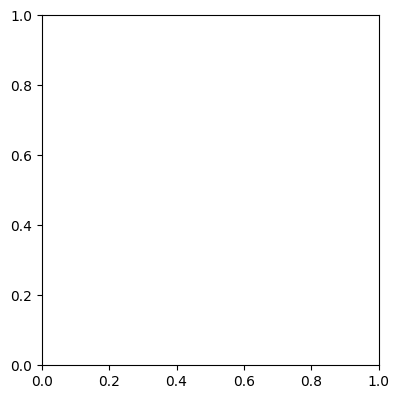

In [16]:
import torch.nn.functional as F
from IPython import display

# Different initializations for the image
# x_0 = torch.ones_like(y)
x_0 = y

# Different initializations for the kernel
gaussianblur = blur.GaussianBlur(k_size, 6.0).to(device)

# k_0 = gaussianblur.get_kernel().view(1, 1, k_size, k_size).to(device)
# k_0 = torch.ones_like(k) / torch.sum(torch.ones_like(k))
k_0 = k_ref

steps = 30
k_steps = 10
im_steps = 1

filter_epsilon = 1e-12
clip = True
observation = y
observation_L = torch.sum(y, dim=1, keepdim=True)

with torch.no_grad():

    k = k_0.clone().float()
        
    im_deconv = x_0.clone().float()
    im_deconv_L = torch.sum(im_deconv, dim=1, keepdim=True)
    
    k_T = torch.flip(k, dims=[2, 3])  
    im_deconv_T = torch.flip(im_deconv, dims=[2, 3])
    im_deconv_L_T = torch.flip(im_deconv_L, dims=[2, 3])
    
    eps = 1e-12
    pad_im = (k.size(2) // 2, k.size(2) // 2, k.size(3) // 2, k.size(3) // 2)
    pad_k = (im_deconv.size(2) // 2, im_deconv.size(2) // 2, im_deconv.size(3) // 2, im_deconv.size(3) // 2)
    
    for i in range(steps):
        
        # Display the image
        display.clear_output(wait=True)  # Clear the previous output

        plt.figure(figsize=(20, 10))
        plt.subplot(2, 4, 1)
        plt.imshow(im_deconv[0].permute(1, 2, 0).cpu().numpy())
        plt.title('Estimated image')
        plt.subplot(2, 4, 2)
        plt.imshow(ref[0].permute(1, 2, 0).cpu().numpy())
        plt.title('Reference image')
        plt.subplot(2, 4, 3)
        plt.imshow(k[0, 0].cpu().numpy(), cmap="gray")
        plt.title('Estimated kernel')
        plt.subplot(2, 4, 4)
        plt.imshow(k_ref[0, 0].cpu().numpy(), cmap="gray")
        plt.title('Reference kernel')
        plt.subplot(2, 4, 5)
        plt.imshow(x_0[0].permute(1, 2, 0).cpu().numpy())
        plt.title('Initial image')
        plt.subplot(2, 4, 7)
        plt.imshow(k_0[0, 0].cpu().numpy(), cmap="gray")
        plt.title('Initial kernel')
        plt.show()
        
        print("Step : ", i)
        
        # Kernel estimation
        # The issue with the offset is probably here, as there is no offset when using k as initialization
        
        for m in range(k_steps):      
            
            k = k.swapaxes(0, 1)
            conv11 = F.conv2d(F.pad(im_deconv_L, pad_im, mode='replicate'), k) + eps
            
            if filter_epsilon:
                relative_blur = torch.where(conv11 < filter_epsilon, 0.0, observation_L / conv11)
            else:
                relative_blur = observation_L / conv11
            
            k = k.swapaxes(0, 1)
            im_deconv_L_T = im_deconv_L_T.swapaxes(0, 1)
            im_mean = F.conv2d(torch.ones_like(F.pad(k, pad_k)), im_deconv_L_T)
            # im_mean = F.conv2d(F.pad(torch.ones_like(k), pad_k, mode='replicate'), im_deconv_T)
            
            if filter_epsilon:
                k = torch.where(im_mean < filter_epsilon, 0.0, k / im_mean)
            else:
                k /= im_mean

            conv12 = F.conv2d(F.pad(relative_blur, pad_k, mode='replicate'), im_deconv_L_T) + eps
            conv12 = conv12[:,:,
                        conv12.size(2) // 2 - k.size(2) // 2:conv12.size(2) // 2 + k.size(2) // 2 + 1,
                        conv12.size(3) // 2 - k.size(3) // 2:conv12.size(3) // 2 + k.size(3) // 2 + 1]
            k *= conv12
            k_T = torch.flip(k, dims=[2, 3]) 
        
        k = k / k.sum()

        # For RGB images
        if(x_0.shape[1] == 3):
            k = k.repeat(1, 3, 1, 1)
            k_T = k_T.repeat(1, 3, 1, 1)
            
        # Image estimation

        for n in range(im_steps):
            
            k = k.swapaxes(0, 1)
            
            conv21 = F.conv2d(F.pad(im_deconv, pad_im, mode='replicate'), k, groups=3) + eps
            
            if filter_epsilon:
                relative_blur = torch.where(conv21 < filter_epsilon, 0.0, observation / conv21)
            else:
                relative_blur = observation / conv21
            
            # k_mean = F.conv2d(F.pad(torch.ones_like(im_deconv), pad_im, mode='replicate'), k_T)
            k_T = k_T.swapaxes(0, 1)
            k_mean = F.conv2d(torch.ones_like(F.pad(im_deconv, pad_im)), k_T, groups=3)
            if filter_epsilon:
                im_deconv = torch.where(k_mean < filter_epsilon, 0.0, im_deconv / k_mean)
            else:
                im_deconv /= k_mean
            
            im_deconv *= F.conv2d(F.pad(relative_blur, pad_im, mode='replicate'), k_T, groups=3) + eps
            
            k_T = k_T.swapaxes(0, 1)
            k = k.swapaxes(0, 1)
        
        k = k[:, 0:1, :, :]
        k_T = k_T[:, 0:1, :, :]
        im_deconv_L = torch.sum(im_deconv, dim=1, keepdim=True)
        im_deconv_L_T = torch.flip(im_deconv_L, dims=[2, 3])
        
        if clip:
            im_deconv = torch.clamp(im_deconv, 0, 1)
            
        im_deconv_T = torch.flip(im_deconv, dims=[2, 3])
        
